### Grouping Analysis

Set up and defining the md_chart function

In [2]:
import pandas as pd #dataframe manipulation
import numpy as np #number stuff
import seaborn as sns #quick visualizations
import matplotlib.pyplot as plt #more visualizations
import sklearn.preprocessing as skp #standardization stuff
from sklearn.decomposition import PCA #PCA tool
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import mahalanobis
from scipy.stats import f

In [3]:
def md_chart(df, group_col, p_val=0.05):
    """
     Returns a dataframe containing mahalanobis distance and probability of group membership between each sample and each group. Suggests the best group for each sample as well.
     Note: Needs more samples than variables. Use less principal components if necesssary.
    
    Parameters
    ----------
    
    df: pandas dataframe with samples on rows and variables across rows.
    
    group_col: string
        column name with assigned group. Column values should be int.

    p_val: float
        default: 0.05. The default significance value. - NOT used currently.
        
    Returns
    -------
    
    pandas dataframe object


    """
    
    #Pull out just the measurement columns
    measurement_columns = list(df.columns)
    measurement_columns.remove(group_col)
    result_df = pd.DataFrame(index=df.index, columns=['assigned_group','suggested_group'])
    groups_columns = []
    for g in df[group_col].unique():
        result_df['mhd_gp'+str(g)]=np.nan
        result_df['in_gp'+str(g)]=np.nan
        groupy = 'in_gp'+str(g)
        groups_columns.append(groupy) #for use later when suggesting a group
    
    #This is a for loop to get through all the samples in the input dataframe
    for sample in df.index:
        
        #This is for jacknife mahalanobis (leave one out)
        sample_only = df.loc[df.index == sample, measurement_columns]
        #everything that is not the sample to be distanced. Leaving in the group column to use it later
        non_sample = df.loc[df.index != sample,:]
        result_df.loc[result_df.index==sample, 'assigned_group'] = df.loc[df.index==sample, group_col]
        
        #iterating through all the groups provided
        for g in df[group_col].unique():
            
            #The meat of the mahalanobis stuff
            group = non_sample.loc[non_sample[group_col]==g, measurement_columns] #dropping the group column
            group_mean = group.mean() #finding the group mean
            
            #using a psuedo-inverse covariance matrix, this is used for groups with small n.
            group_psuedo_inverse_covariance = np.linalg.pinv(group.cov())
            
            #using scipy mahalanobis distance measure function
            mhd = mahalanobis(sample_only, group_mean, group_psuedo_inverse_covariance)
            
            #using the Wilks method to generate critical values
            n = len(group)+1
            p = len(group.columns)
            g_col = 'mhd_gp'+str(g)
            g_crit_col = 'in_gp'+str(g)
            
            result_df.loc[result_df.index==sample,g_col] = mhd**2
            result_df.loc[result_df.index==sample,g_crit_col] = round((f.sf((((n-p-1)/(p*(n-2)))*(mhd**2)),p,(n-p-1))*100),5)
        
        max_group = result_df.loc[result_df.index==sample, groups_columns].idxmax(axis=1)
        
        max_val = result_df.loc[result_df.index==sample, [str(max_group.iloc[0])]]
        
        if float(int(max_val.iloc[0])) >0.001:
            val = str(max_group.iloc[0])
            val = int(val[-1])
            result_df.loc[result_df.index==sample, 'suggested_group'] = val
        else:
            
            result_df.loc[result_df.index==sample, 'suggested_group'] = 'All group probabilities are < 0.001 '
    
    
    return(result_df)


### PCA

Principal Component Analysis is best when the data is standardized in some why it can be transformed to lob10 or scaled using standard deviation and the mean of the values. Here we are using the scikit learn scale function which uses the standard deviation and mean to produce the scaled values. 

In [4]:
d = pd.read_csv('final_data')
t = pd.read_csv('final_2colors')

In [5]:
data = d.iloc[:,1:]
twoco = t.iloc[:,1:]

In [6]:
data_clean = pd.DataFrame(skp.scale(data), columns=list(data.columns))

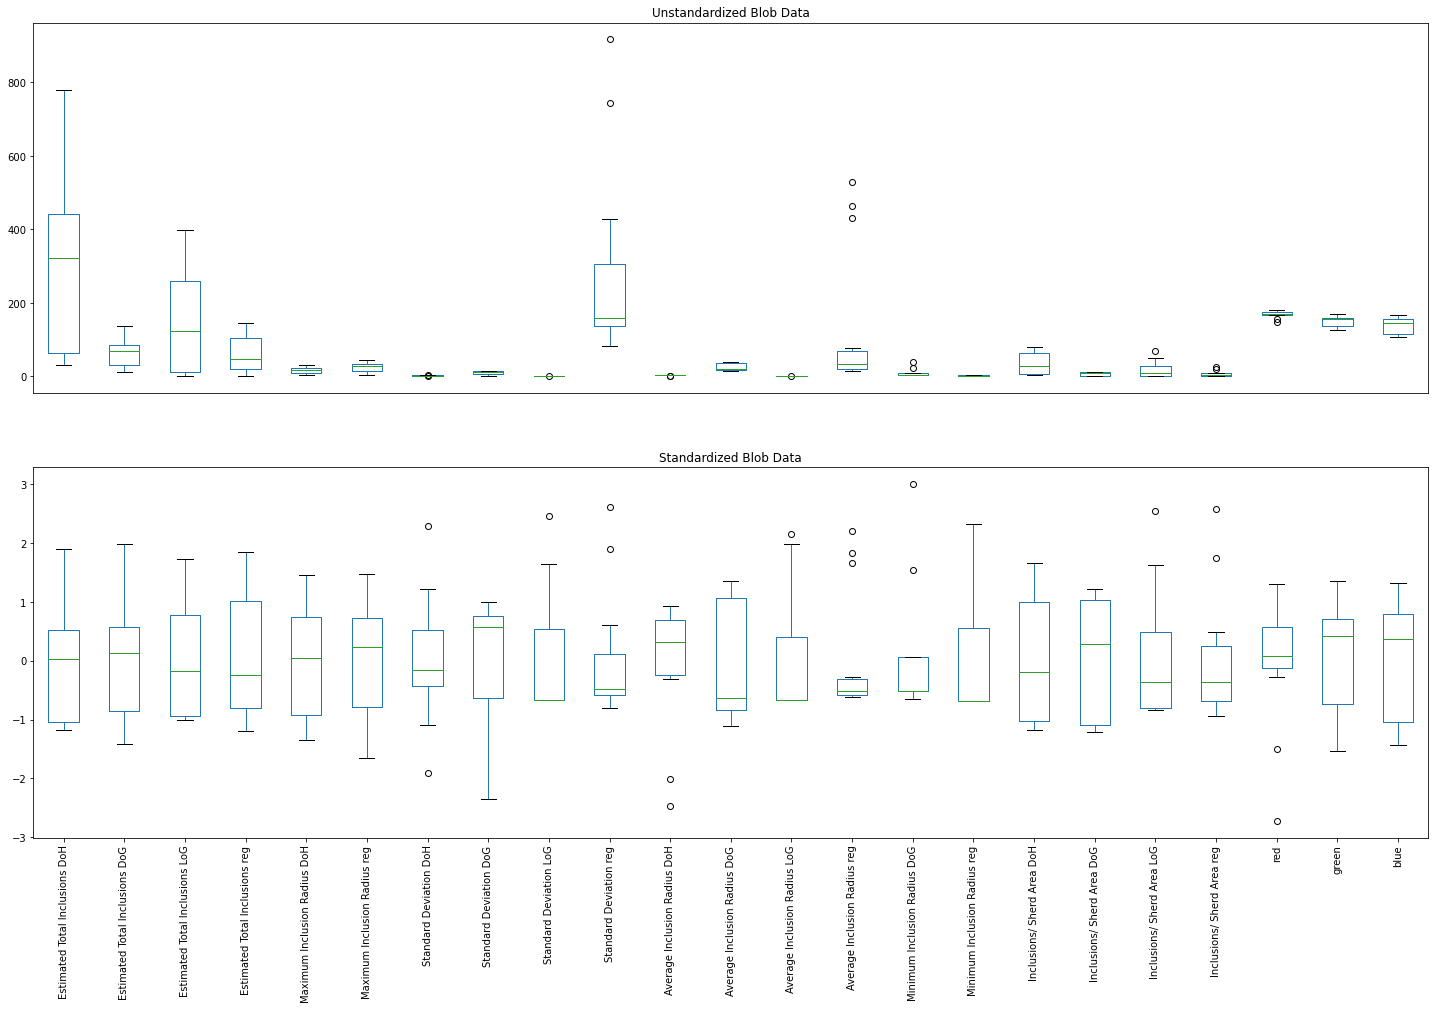

In [7]:
fig, ax = plt.subplots(nrows=2,figsize=(25,15))
data.boxplot(ax=ax[0], grid=False)
ax[0].get_xaxis().set_visible(False)
ax[0].set_title('Unstandardized Blob Data')
data_clean.boxplot(ax=ax[1],grid=False)
ax[1].set_title('Standardized Blob Data')
ax[1].tick_params(axis='x', labelrotation = 90);


The scale function works pretty well and manages to scale all the values around 0. 

Here we wrote a small function to perform the PCA on each of the datasets.

In [8]:
def pca(data):
    """ generates a PCA object and the pca_data for graphing. 
    Use like: pca_object, pca_data = pca(data)

    Parameters
    ----------
    data: array-like
        array of sample data for the pca.
    
    Returns
    -------
    PCA object
    Dataframe of samples projected onto princple components. Samples as rows, principle components as columns
    
    """
    pca = PCA()
    pca.fit(data)
    pca_data = pca.transform(data)
    pca_df = pd.DataFrame(pca_data)
    pca_df.columns = ['PC' + str(x) for x in range(1,len(pca_df.columns)+1)]
    return pca,pca_df

In [9]:
data_nocol = data_clean.iloc[:,:-3]

In [10]:
data_pca, datapca_df = pca(data_clean)
noco_pca, noco_df = pca(data_nocol)

Another small function to produce variance numbers

In [11]:
def pc_variance(pca):
    """ This function produces an arrray of principle component variance values as percentages.
    
    Parameters
    ----------
    pca: PCA class object
    
    Returns
    -------
    variance_df: Pandas DataFrame object with two columns
    'PC' containing Principle component numbers and 'Variance' containing variance explained
    """
    per_var = np.round(pca.explained_variance_ratio_*100, decimals=4) # variances rounded out and made an array
    labels = ['PC' + str(x) for x in range(1,len(per_var)+1)] #labels equal to the number of PCs
    dict_combo = {'PC':labels,'Variance':per_var}
    variance_df = pd.DataFrame(dict_combo)
    return variance_df

In [12]:
variance = pc_variance(data_pca)
varnoco = pc_variance(noco_pca)

In [13]:
print(variance[:3].sum())
print(varnoco[:3].sum())

PC          PC1PC2PC3
Variance       83.285
dtype: object
PC          PC1PC2PC3
Variance      84.3966
dtype: object


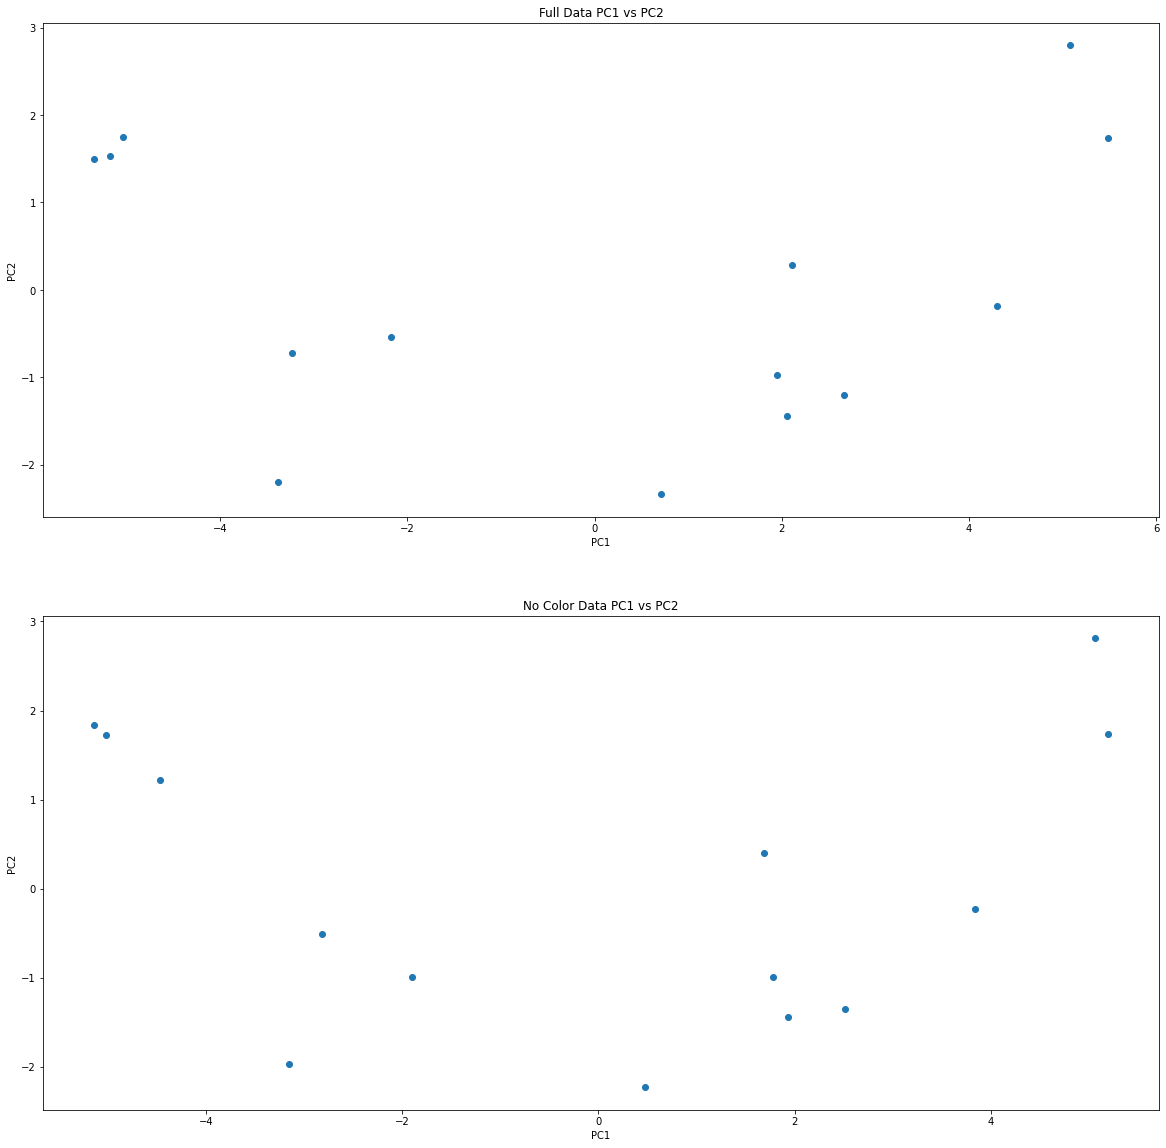

In [14]:
fig, ax = plt.subplots(nrows=2, figsize=(20,20))
ax[0].scatter(datapca_df['PC1'], datapca_df['PC2'])
ax[0].set_title('Full Data PC1 vs PC2')
ax[0].set_ylabel('PC2')
ax[0].set_xlabel('PC1')
ax[1].scatter(noco_df['PC1'],noco_df['PC2'])
ax[1].set_title('No Color Data PC1 vs PC2')
ax[1].set_ylabel('PC2')
ax[1].set_xlabel('PC1');

## Groups

We selected out the groups and organized them into the following CSVs

In [15]:
gp1 = pd.read_csv('group1.txt')
gp2 = pd.read_csv('group2.txt')
gp3 = pd.read_csv('group3.txt')
gp4 = pd.read_csv('group4.txt')

In [16]:
dpc = datapca_df.copy()

In [17]:
dpc['group'] = 'na'
dpc.loc[gp3['index'],'group'] = 3
dpc.loc[gp2['index'],'group'] = 2
dpc.loc[gp1['index'],'group'] = 1
dpc.loc[gp4['index'],'group'] = 4


''

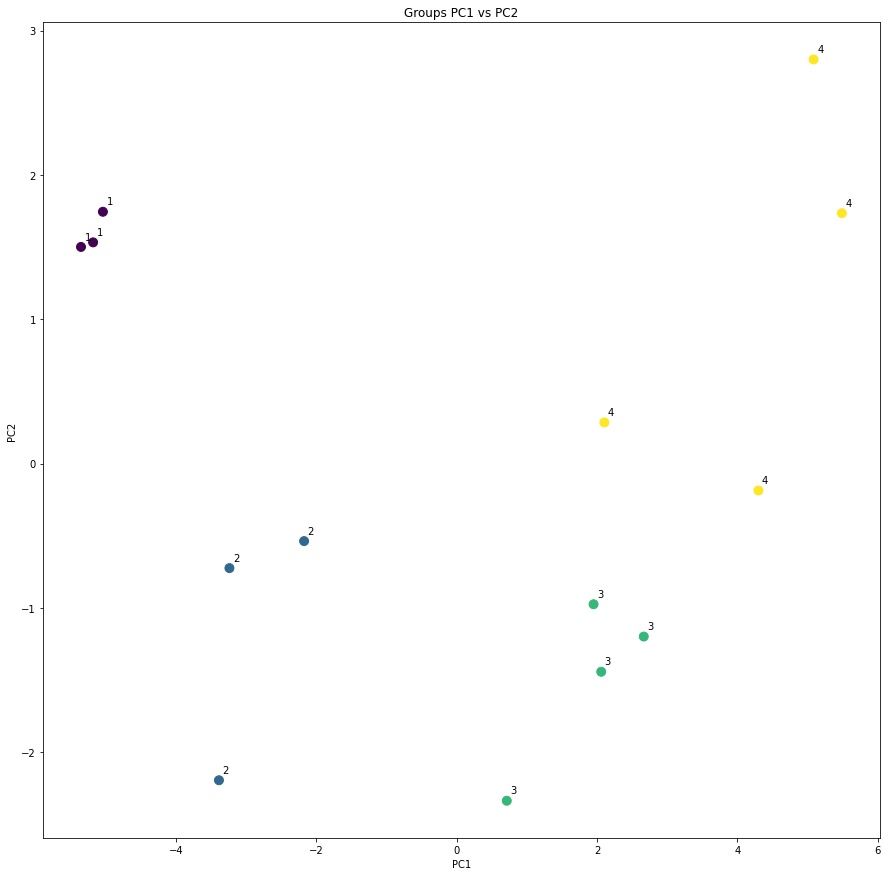

In [18]:
fig, ax = plt.subplots(nrows=1, figsize=(15,15))
ax.scatter(dpc['PC1'], dpc['PC2'],c=dpc['group'],s=80)
ax.set_title('Groups PC1 vs PC2')
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')

for sample in dpc.index:
    ax.annotate(str(dpc.loc[sample,'group']), ((dpc['PC1'].loc[sample]+.05), (dpc['PC2'].loc[sample])+.05),)
;

In [19]:
dpc2 = dpc.iloc[:,[0,1,2,14]]

### Mahalanobis group analysis

The group fit maths breaks down with small group size compared to the number of variables. This is why a lot of NaN are showing up. However, the groups are are trending towards two and are fairly consistent. A better method will be to use a clustering method. 

In [20]:
m_data = md_chart(dpc2, group_col='group')
m_data

,assigned_group,suggested_group,mhd_gp4,in_gp4,mhd_gp2,in_gp2,mhd_gp1,in_gp1,mhd_gp3,in_gp3
0,4,3,9.609806,NaN,3.526411,NaN,8205.400625,NaN,53.899866,28.97683
1,4,3,44.845569,NaN,6.204272,NaN,4951.255325,NaN,30.711540,37.41120
2,2,3,1655.414585,5.41369,0.745142,NaN,544.333827,NaN,1042.759530,6.81627
3,1,3,4093.249642,3.44528,8.689163,NaN,241.887030,NaN,2829.782756,4.14274
4,1,4,525.344530,9.58519,14.429597,NaN,0.380154,NaN,1457.561153,5.76849
5,2,4,29.953376,37.82564,0.323554,NaN,220.060174,NaN,413.983312,10.78673
6,3,4,31.229085,37.13599,0.760639,NaN,5089.077635,NaN,5.210752,NaN
7,3,4,17.042276,48.00222,0.204039,NaN,4256.976549,NaN,0.110836,NaN
8,3,4,2.984141,81.91523,0.542539,NaN,4256.891932,NaN,2.007284,NaN
9,3,4,95.884391,22.06456,1.417660,NaN,2482.503081,NaN,16.472226,NaN


In [21]:
from mpl_toolkits import mplot3d

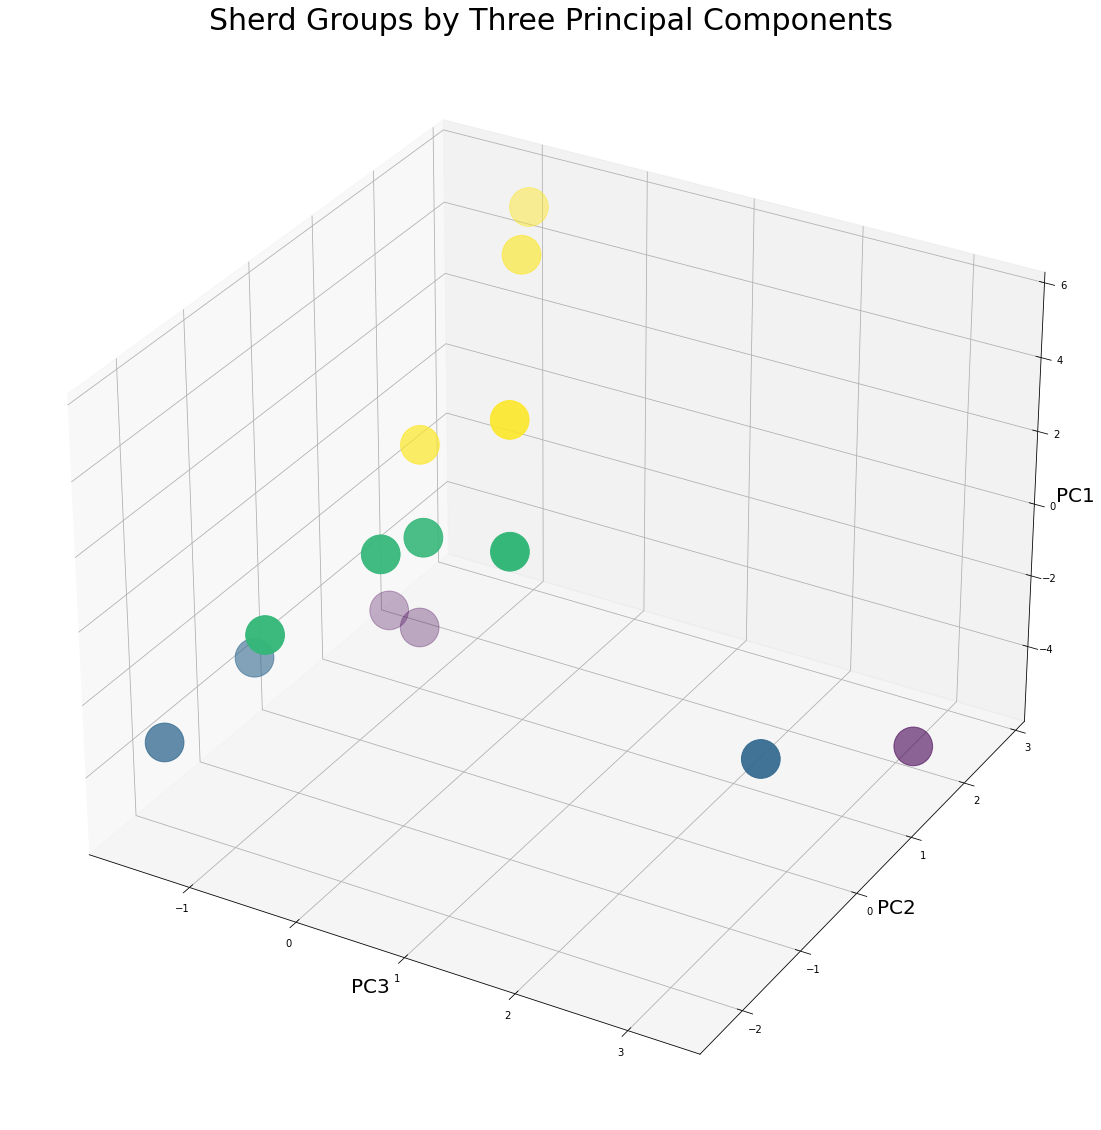

In [22]:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.scatter3D(zs=dpc.PC1, ys=dpc.PC2, xs=dpc.PC3, c=dpc.group, s= 1500, )
ax.set_xlabel('PC3',fontdict = {'fontsize' : 20})
ax.set_ylabel('PC2',fontdict = {'fontsize' : 20})
ax.set_zlabel('PC1', fontdict = {'fontsize' : 20})
ax.set_title('Sherd Groups by Three Principal Components',fontdict = {'fontsize' : 30});

### Clustering

Here we are using a clustering function from scikit learn. The clustering here, with the full PCA set clusters the sherd pairs fairly well. 

In [23]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram


Clusters using the PCA Dataframe

In [35]:
eight_pc = datapca_df.iloc[:,:8]

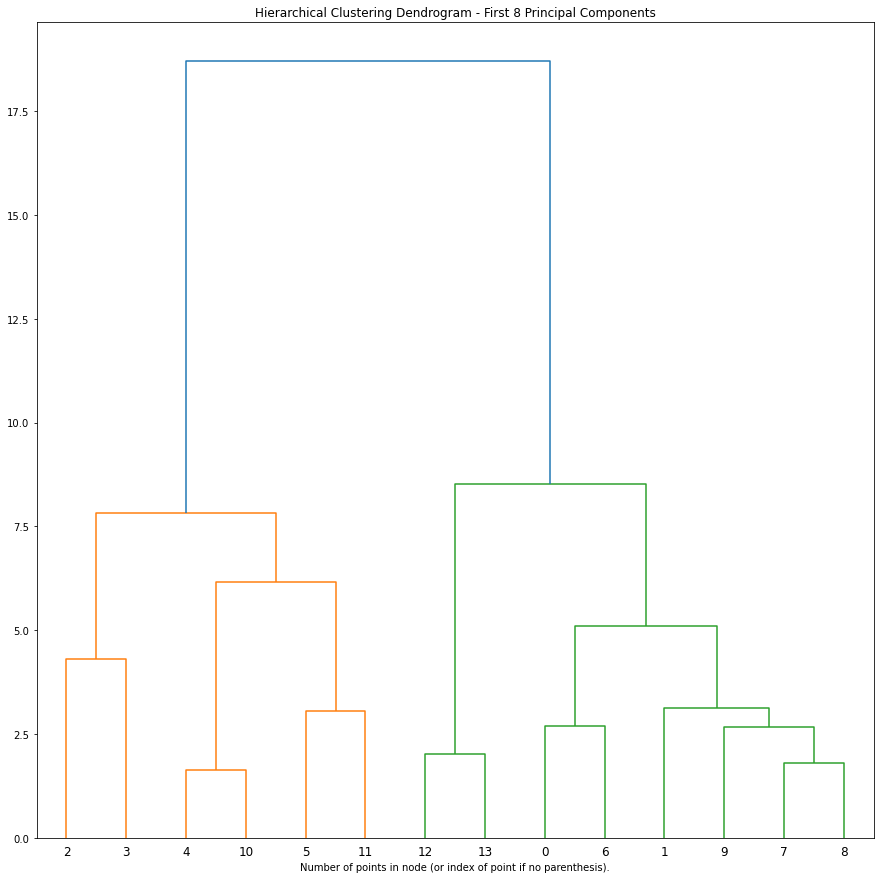

In [36]:
clusty = AgglomerativeClustering(n_clusters=4, linkage='ward', distance_threshold=None, compute_distances=True).fit(eight_pc)
fig, ax = plt.subplots(figsize=(15,15))
plt.title('Hierarchical Clustering Dendrogram - First 8 Principal Components')
# plot the top three levels of the dendrogram

counts = np.zeros(clusty.children_.shape[0])
n_samples = len(clusty.labels_)
for i, merge in enumerate(clusty.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
        counts[i] = current_count

linkage_matrix = np.column_stack([clusty.children_, clusty.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
dendrogram(linkage_matrix)


plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Clusters using the raw data

In [37]:
clusty = AgglomerativeClustering(n_clusters=4, linkage='ward', distance_threshold=None, compute_distances=True).fit(datapca_df)

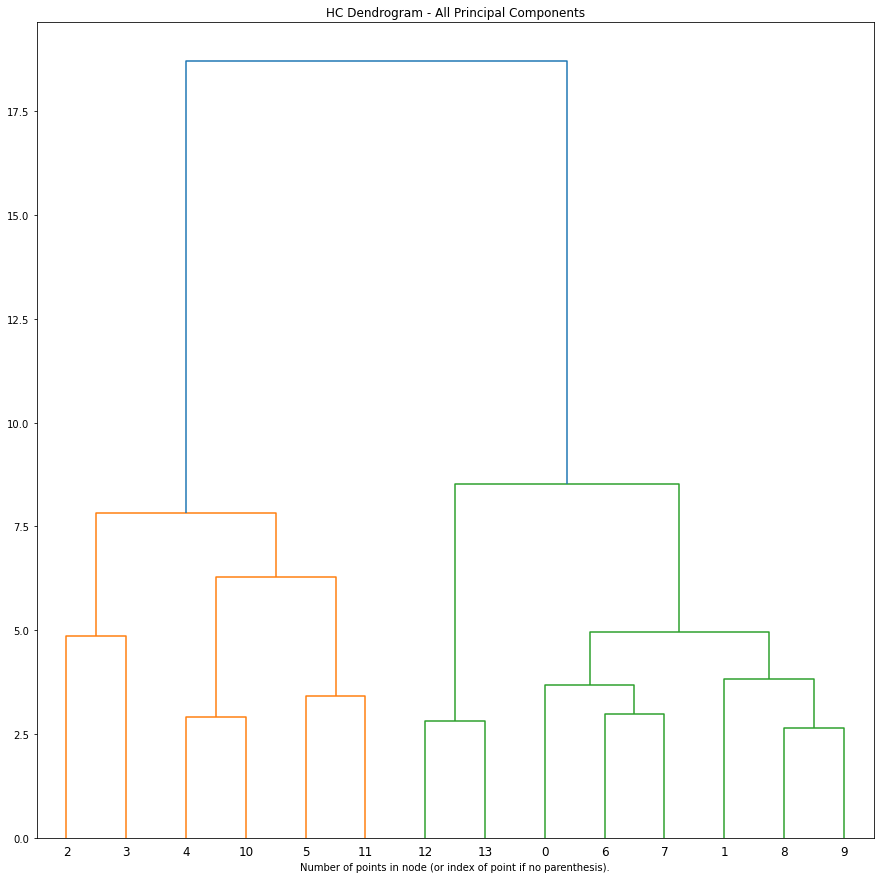

In [39]:
fig, ax = plt.subplots(figsize=(15,15))
plt.title('HC Dendrogram - All Principal Components')
# plot the top three levels of the dendrogram
counts = np.zeros(clusty.children_.shape[0])
n_samples = len(clusty.labels_)
for i, merge in enumerate(clusty.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
        counts[i] = current_count

linkage_matrix = np.column_stack([clusty.children_, clusty.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
dendrogram(linkage_matrix)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()